In [1]:
import numpy as np
import pandas as pd
import string
import nltk
import itertools
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')
spam_dataset = pd.read_csv('spam.csv', encoding = "ISO-8859-1", usecols=[0, 1], names=['Spam', 'Text'], skiprows=1)
spam_dataset['Spam'] = spam_dataset['Spam'].replace(['ham', 'spam'], [0, 1])

def remove_puncation(text):
    cleaned = ''.join([word for word in text if word not in string.punctuation])
    return cleaned
spam_dataset['Cleaned_Text'] = spam_dataset['Text'].apply(lambda x: remove_puncation(x))

nltk.download('punkt_tab')
def tokenize(text):

    # Usunięcie wielkich liter
    clean_text = text.lower()

    # Tokenizacja
    tokenized_text = nltk.word_tokenize(clean_text)
    return tokenized_text

spam_dataset['Tokenized_Text'] = spam_dataset['Cleaned_Text'].apply(lambda x: tokenize(x))


nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

def remove_stopwords(text):
    without_stopwords = [word for word in text if word not in stopwords]
    return without_stopwords
spam_dataset['WithoutStop_Text'] = spam_dataset['Tokenized_Text'].apply(lambda x: remove_stopwords(x))

stemmer = nltk.PorterStemmer()
def stemming(text):
    stemmed_words = [stemmer.stem(word) for word in text]
    return stemmed_words
spam_dataset['Stemmed_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: stemming(x))

nltk.download('wordnet')
lemmater = nltk.WordNetLemmatizer()
def lemmatizing(text):
    lemmatized_words = [lemmater.lemmatize(word) for word in text]
    return lemmatized_words
spam_dataset['Lemmatized_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: lemmatizing(x))



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pzeleznicki\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\pzeleznicki\AppData\Local\Temp\ipykernel_28020\47160941.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  spam_dataset['Spam'] = spam_dataset['Spam'].replace(['ham', 'spam'], [0, 1])
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\pzeleznicki\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pzeleznicki\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pzeleznicki\App

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
X = spam_dataset['Lemmatized_Text']
y = spam_dataset['Spam']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify =y)

tfidf = TfidfVectorizer()
# Uczysz słownik tylko na danych treningowych
X_train_tfidf = tfidf.fit_transform(X_train.apply(lambda x: ' '.join(x)))

# Przekształcasz testowe dane tylko transformem
X_test_tfidf = tfidf.transform(X_test.apply(lambda x: ' '.join(x)))

In [3]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train_tfidf, y_train)
clf.score(X_train_tfidf, y_train)

0.8658290329818263

In [4]:
clf.score(X_test_tfidf, y_test)

0.8663677130044843

In [5]:
importances = clf.feature_importances_   #Sprawdza ważność cech z modelu
feature_names = tfidf.get_feature_names_out()  #łaczy ważność z nazwami cech (słów)

#Filtracja cech
important_indices = [i for i in range(len(importances)) if importances[i] > 0.001]
important_feature_names = [feature_names[i] for i in important_indices]

#Selekcja cech w danych
X_train_selected = X_train_tfidf[:, important_indices]
X_test_selected = X_test_tfidf[:, important_indices]

clf.fit(X_train_selected, y_train)
clf.score(X_test_selected, y_test)

0.874439461883408

In [6]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    'n_estimators': [50, 100, 200],  # Liczba drzew w lesie
    'max_depth': [10, 20, 30, None],  # Głębokość drzewa
    'min_samples_split': [2, 5, 10],  # Minimalna liczba próbek do podziału
    'min_samples_leaf': [1, 2, 4],    # Minimalna liczba próbek w liściu
    'max_features': ['sqrt', 'log2', None]  # Liczba cech przy podziale
}

# Utworzenie modelu RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Inicjalizacja GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

grid_search.fit(X_train_selected, y_train)
best_params = grid_search.best_params_
print("Najlepsze parametry: ", best_params)
best_model = grid_search.best_estimator_

test_score = best_model.score(X_test_selected, y_test)
print(f"Dokładność na zbiorze testowym: {test_score:.4f}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Najlepsze parametry:  {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Dokładność na zbiorze testowym: 0.9686


Dokładność (Accuracy): 0.9686
Precyzja (Precision): 0.9688
Czułość (Recall): 0.9686
F1-score: 0.9671

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       0.97      0.79      0.87       149

    accuracy                           0.97      1115
   macro avg       0.97      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



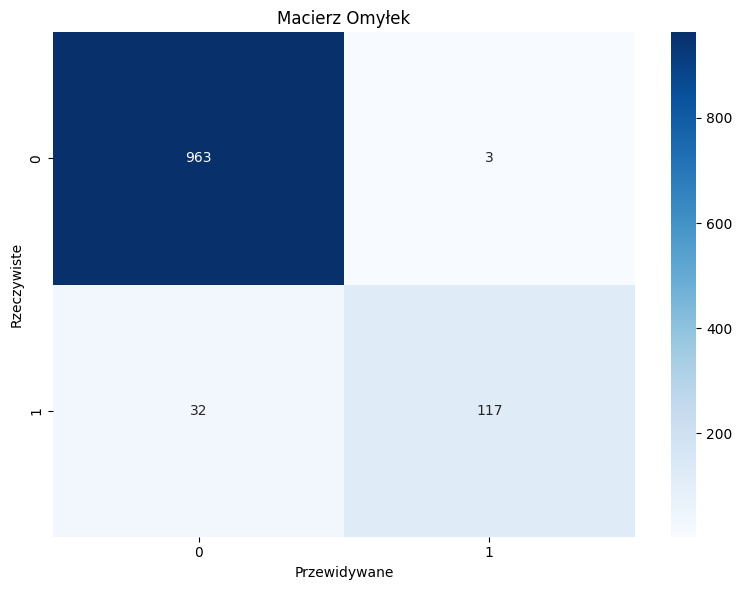

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Predykcje
y_pred = best_model.predict(X_test_selected)

# Metryki klasyfikacji
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Dokładność (Accuracy): {accuracy:.4f}")
print(f"Precyzja (Precision): {precision:.4f}")
print(f"Czułość (Recall): {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Macierz omyłek
cm = confusion_matrix(y_test, y_pred)

# Wizualizacja macierzy omyłek
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.title('Macierz Omyłek')
plt.tight_layout()
plt.show()